# NBA-Salary-Analysis

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, r2_score, explained_variance_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor

# Functions

In [2]:
def check_for_nulls_dupes(df):
  print(f"The amount of Null Values: {df.isna().sum()}")
  print(f"The amount of Duplicated Values {df.duplicated().sum()}")

def create_preprocessor(int_features, cat_features):

  numeric_transformer = Pipeline(steps=[
    ("Simple-Imputer", SimpleImputer(missing_values=np.nan, strategy="median")),
    ("Scaler", MinMaxScaler()),
    ("PowerTransformer", PowerTransformer())
  ])
  
  cat_transformer = Pipeline(steps=[
    ("Encoder", OneHotEncoder())
  ])
  
  return ColumnTransformer(transformers=[
    ("Numeric", numeric_transformer, int_features),
    ("cat", cat_transformer, cat_features)
  ])

def create_sklearn_pipeline(preprocessor, model, kbest=None):
  
  steps = [
    ("Preprocessor", preprocessor),
    ("Model", model)
  ]
  
  if kbest:
    steps.insert(1, ("Feature Selector", kbest))
  
  return Pipeline(steps=steps)

def pca_analysis(X, preprocessor):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []
  for component in features:
    pca = PCA(n_components=component)
    pipeline = create_sklearn_pipeline(preprocessor, pca)
    X_pca = pipeline.fit_transform(X)
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append(
      {
        "Component": component,
        "CumSum": cumsum
      }
    )
  
  return pd.DataFrame(metric_tracker)

def grab_selected_models(names):
    models = {
        "SVR": SVR(),
        "LR": LinearRegression(),
        "KNN": KNeighborsRegressor(),
        "DTR": DecisionTreeRegressor(),
        "GBR": GradientBoostingRegressor(),
        "RFR": RandomForestRegressor(),
        "XGB": XGBRegressor(),
        "DUMMY": DummyRegressor(strategy="mean")
    }

def get_metrics(y, predictions):
    mae = mean_absolute_error(y, predictions)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r2 = r2_score(y, predictions)
    exp = explained_variance_score(y, predictions)
    
    return [mae, mse, rmse, r2, exp]

def evaluate_model(model, X, y, metric):
    cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)
    scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
    preds = cross_val_predict(model, X, y, n_jobs=-1, cv=10)
    mae, mse, rmse, r2, exp = get_metrics(y, preds)
    
    return [
        round(np.mean(scores), 3), 
        round(np.var(scores), 3), 
        round(np.std(scores), 3), 
        round(mae, 3), 
        round(mse, 3),
        round(rmse, 3),
        round(r2, 3),
        round(exp, 3)
    ]

def test_selected_models(sample_model, model_names, models, X, y, scoring_metric, kbest=None):
    metric_tracker = []
    
    for model, model_name in zip(models, model_names):
        pipeline = create_sklearn_pipeline(sample_model, model, kbest) if kbest else create_sklearn_pipeline(sample_model, model) 
        scores = evaluate_model(pipeline, X, y, scoring_metric)
        metric_tracker.append({
            "Model": model_name,
            "Mean": scores[0],
            "Var": scores[1],
            "STD": scores[2],
            "MAE": scores[3],
            "MSE": scores[4],
            "RMSE": scores[5],
            "R2": scores[6],
            "Explained Var": scores[7]
        })
    
    performance_df = pd.DataFrame(metric_tracker).sort_values(by="Mean", ascending=False)
    print(performance_df)
  

# NBA 2022-2023 Season

#### Nba Champion = Nuggets

## East Stanings:

- Bucks
- Celtics
- 76ers
- Cavaliers
- Knicks
- Nets
- Hawks
- Heat
- Raptors
- Bulls
- Pacers
- Wizards
- Magic
- Hornets
- Pistons

## West Stanings:

- Nuggets
- Grizzlies
- Kings
- Suns
- Clippers
- Warriors
- Lakers
- Timberwolves
- Pelicans
- Thunder
- Mavericks
- Jazz
- Trail Blazers
- Rockets
- Spurs

# EDA Analysis

In [3]:
player_salary = pd.read_csv("/Users/maukanmir/Downloads/archive/nba_salaries.csv")
team_salary = pd.read_csv("/Users/maukanmir/Downloads/archive/nba-team-salary.csv")

In [4]:
player_salary

,Unnamed: 0,Player Name,Salary,Position,Age,Team,GP,GS,MP,FG,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,0,Stephen Curry,48070014,PG,34,GSW,56,56,34.7,10.0,...,0.7,5.4,6.1,6.3,0.9,0.4,3.2,2.1,29.4,curryst01
1,1,John Wall,47345760,PG,32,LAC,34,3,22.2,4.1,...,0.4,2.3,2.7,5.2,0.8,0.4,2.4,1.7,11.4,walljo01
2,2,Russell Westbrook,47080179,PG,34,LAL/LAC,73,24,29.1,5.9,...,1.2,4.6,5.8,7.5,1.0,0.5,3.5,2.2,15.9,westbru01
3,3,LeBron James,44474988,PF,38,LAL,55,54,35.5,11.1,...,1.2,7.1,8.3,6.8,0.9,0.6,3.2,1.6,28.9,jamesle01
4,4,Kevin Durant,44119845,PF,34,BRK/PHO,47,47,35.6,10.3,...,0.4,6.3,6.7,5.0,0.7,1.4,3.3,2.1,29.1,duranke01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,462,Justin Minaya,35096,SF,23,POR,4,0,22.3,1.8,...,0.8,3.0,3.8,1.0,0.5,1.3,1.0,2.3,4.3,minayju01
463,463,Kobi Simmons,32795,SG,25,CHO,5,0,5.6,0.2,...,0.2,0.6,0.8,1.0,0.0,0.4,0.2,0.0,1.0,simmoko01
464,464,Gabe York,32171,SG,29,IND,3,0,18.7,2.7,...,0.0,2.0,2.0,1.7,0.7,0.0,0.0,1.7,8.0,yorkga01
465,465,RaiQuan Gray,5849,PF,23,BRK,1,0,35.0,6.0,...,3.0,6.0,9.0,7.0,0.0,1.0,4.0,5.0,16.0,grayra01


# Check For Nulls and Dupes

In [5]:
check_for_nulls_dupes(player_salary)

The amount of Null Values: Unnamed: 0            0
Player Name           0
Salary                0
Position              0
Age                   0
Team                  0
GP                    0
GS                    0
MP                    0
FG                    0
FGA                   0
FG%                   1
3P                    0
3PA                   0
3P%                  13
2P                    0
2PA                   0
2P%                   4
eFG%                  1
FT                    0
FTA                   0
FT%                  23
ORB                   0
DRB                   0
TRB                   0
AST                   0
STL                   0
BLK                   0
TOV                   0
PF                    0
PTS                   0
Player-additional     0
dtype: int64
The amount of Duplicated Values 0


In [6]:
player_salary[player_salary["FT%"].isna()]

,Unnamed: 0,Player Name,Salary,Position,Age,Team,GP,GS,MP,FG,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
221,221,Dylan Windler,4037277,SF,26,CLE,3,0,3.3,0.7,...,0.0,0.0,0.0,0.3,0.3,0.0,0.3,0.0,1.7,windldy01
247,247,Sterling Brown,3122602,SF,27,LAL,4,0,6.0,0.0,...,0.8,1.3,2.0,0.5,0.8,0.0,0.0,1.0,0.0,brownst02
254,254,Joe Wieskamp,2909261,SF,23,TOR,9,0,5.6,0.3,...,0.0,0.4,0.4,0.3,0.0,0.0,0.1,0.3,1.0,wieskjo01
344,344,Ryan Arcidiacono,1836090,PG,28,NYK/POR,20,4,8.6,0.5,...,0.0,0.8,0.8,1.2,0.3,0.0,0.4,0.9,1.3,arcidry01
356,356,Leandro Bolmaro,1709300,SF,22,UTA,14,0,4.9,0.2,...,0.3,0.2,0.5,0.5,0.2,0.1,0.5,0.7,0.4,bolmale01
358,358,Jared Butler,1674655,PG,22,OKC,6,1,12.8,2.5,...,0.2,0.5,0.7,1.3,0.8,0.0,0.8,0.8,6.2,butleja02
393,393,Justin Champagnie,853241,SF,21,BOS/TOR,5,0,6.8,1.0,...,0.6,1.0,1.6,0.8,0.2,0.0,0.0,0.4,2.2,champju01
397,397,PJ Dozier,784654,SF,26,SAC,16,0,4.9,0.6,...,0.1,0.8,0.9,0.6,0.4,0.1,0.3,0.4,1.4,doziepj01
403,403,Trevor Keels,520589,SG,19,NYK,3,0,2.7,0.3,...,0.0,0.7,0.7,0.0,0.0,0.0,0.0,0.0,1.0,keelstr01
404,404,Dereon Seabron,511816,SG,22,NOP,5,0,2.4,0.4,...,0.2,0.0,0.2,0.0,0.0,0.0,0.0,0.2,0.8,seabrde01


In [7]:
player_salary[player_salary["3P%"].isna()]

,Unnamed: 0,Player Name,Salary,Position,Age,Team,GP,GS,MP,FG,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
75,75,Mitchell Robinson,17045454,C,24,NYK,59,58,27.0,3.2,...,4.5,4.9,9.4,0.9,0.9,1.8,0.7,2.7,7.4,robinmi01
133,133,Mason Plumlee,9080417,C,32,LAC/CHO,79,60,26.0,4.2,...,2.9,6.0,8.9,3.1,0.6,0.6,1.5,2.7,10.8,plumlma01
233,233,Mark Williams,3722040,C,21,CHO,43,17,19.3,3.7,...,2.2,4.9,7.1,0.4,0.7,1.0,0.9,2.2,9.0,willima07
264,264,Bismack Biyombo,2905851,C,30,PHO,61,14,14.3,2.0,...,1.5,2.8,4.3,0.9,0.3,1.4,0.8,1.9,4.3,biyombi01
301,301,Udoka Azubuike,2174880,C,23,UTA,36,4,10.0,1.6,...,0.9,2.4,3.3,0.3,0.2,0.4,0.5,0.9,3.5,azubuud01
332,332,Daniel Gafford,1930681,C,24,WAS,78,47,20.6,3.7,...,2.1,3.5,5.6,1.1,0.4,1.3,1.1,2.4,9.0,gaffoda01
395,395,Moses Brown,824041,C,23,BRK/LAC,36,1,8.2,1.7,...,1.6,2.3,3.9,0.1,0.1,0.4,0.4,1.1,4.3,brownmo01
404,404,Dereon Seabron,511816,SG,22,NOP,5,0,2.4,0.4,...,0.2,0.0,0.2,0.0,0.0,0.0,0.0,0.2,0.8,seabrde01
421,421,Neemias Queta,508891,C,23,SAC,5,0,5.8,1.2,...,1.0,1.2,2.2,0.2,0.0,0.4,0.2,1.4,2.4,quetane01
428,428,Chima Moneke,500000,SF,27,SAC,2,0,4.0,0.5,...,1.0,0.0,1.0,0.5,0.0,0.0,1.0,1.0,1.0,monekch01


In [8]:
player_salary[player_salary["eFG%"].isna()]

,Unnamed: 0,Player Name,Salary,Position,Age,Team,GP,GS,MP,FG,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
436,436,Alondes Williams,254446,SG,23,BRK,1,0,5.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,willial06


In [9]:
top_twenty_five_paid = player_salary.sort_values(by="Salary", ascending=False).head(25)

In [10]:
top_twenty_five_pts = player_salary.sort_values(by="PTS", ascending=False).head(25)

In [11]:
player_salary.dtypes

Unnamed: 0             int64
Player Name           object
Salary                 int64
Position              object
Age                    int64
Team                  object
GP                     int64
GS                     int64
MP                   float64
FG                   float64
FGA                  float64
FG%                  float64
3P                   float64
3PA                  float64
3P%                  float64
2P                   float64
2PA                  float64
2P%                  float64
eFG%                 float64
FT                   float64
FTA                  float64
FT%                  float64
ORB                  float64
DRB                  float64
TRB                  float64
AST                  float64
STL                  float64
BLK                  float64
TOV                  float64
PF                   float64
PTS                  float64
Player-additional     object
dtype: object

In [12]:
player_salary.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,467.0,2.330000e+02,1.349555e+02,0.0,1.165000e+02,2.330000e+02,3.495000e+02,466.0
Salary,467.0,8.416599e+06,1.070812e+07,5849.0,1.782621e+06,3.722040e+06,1.063354e+07,48070014.0
Age,467.0,2.582013e+01,4.275113e+00,19.0,2.300000e+01,2.500000e+01,2.900000e+01,42.0
GP,467.0,4.823340e+01,2.480774e+01,1.0,3.100000e+01,5.500000e+01,6.850000e+01,83.0
GS,467.0,2.265096e+01,2.709458e+01,0.0,1.000000e+00,8.000000e+00,4.550000e+01,83.0
MP,467.0,1.987131e+01,9.548684e+00,1.8,1.250000e+01,1.920000e+01,2.830000e+01,41.0
FG,467.0,3.351392e+00,2.457836e+00,0.0,1.600000e+00,2.700000e+00,4.300000e+00,11.2
FGA,467.0,7.117773e+00,5.020700e+00,0.0,3.300000e+00,5.800000e+00,9.400000e+00,22.2
FG%,466.0,4.650086e-01,1.095467e-01,0.0,4.170000e-01,4.550000e-01,5.075000e-01,1.0
3P,467.0,9.965739e-01,8.804682e-01,0.0,3.000000e-01,8.000000e-01,1.500000e+00,4.9


In [13]:
player_salary.drop("Unnamed: 0", axis=1, inplace=True)

# Split Data Types

In [14]:
cat_features

NameError: name 'cat_features' is not defined

In [ ]:
cat_features = player_salary.select_dtypes(include=["object"]).drop(["Player Name", "Team", "Player-additional"], axis=1)
int_features = player_salary.select_dtypes(include=["int64", "float64"])

# SNS Heat Map

<AxesSubplot:>

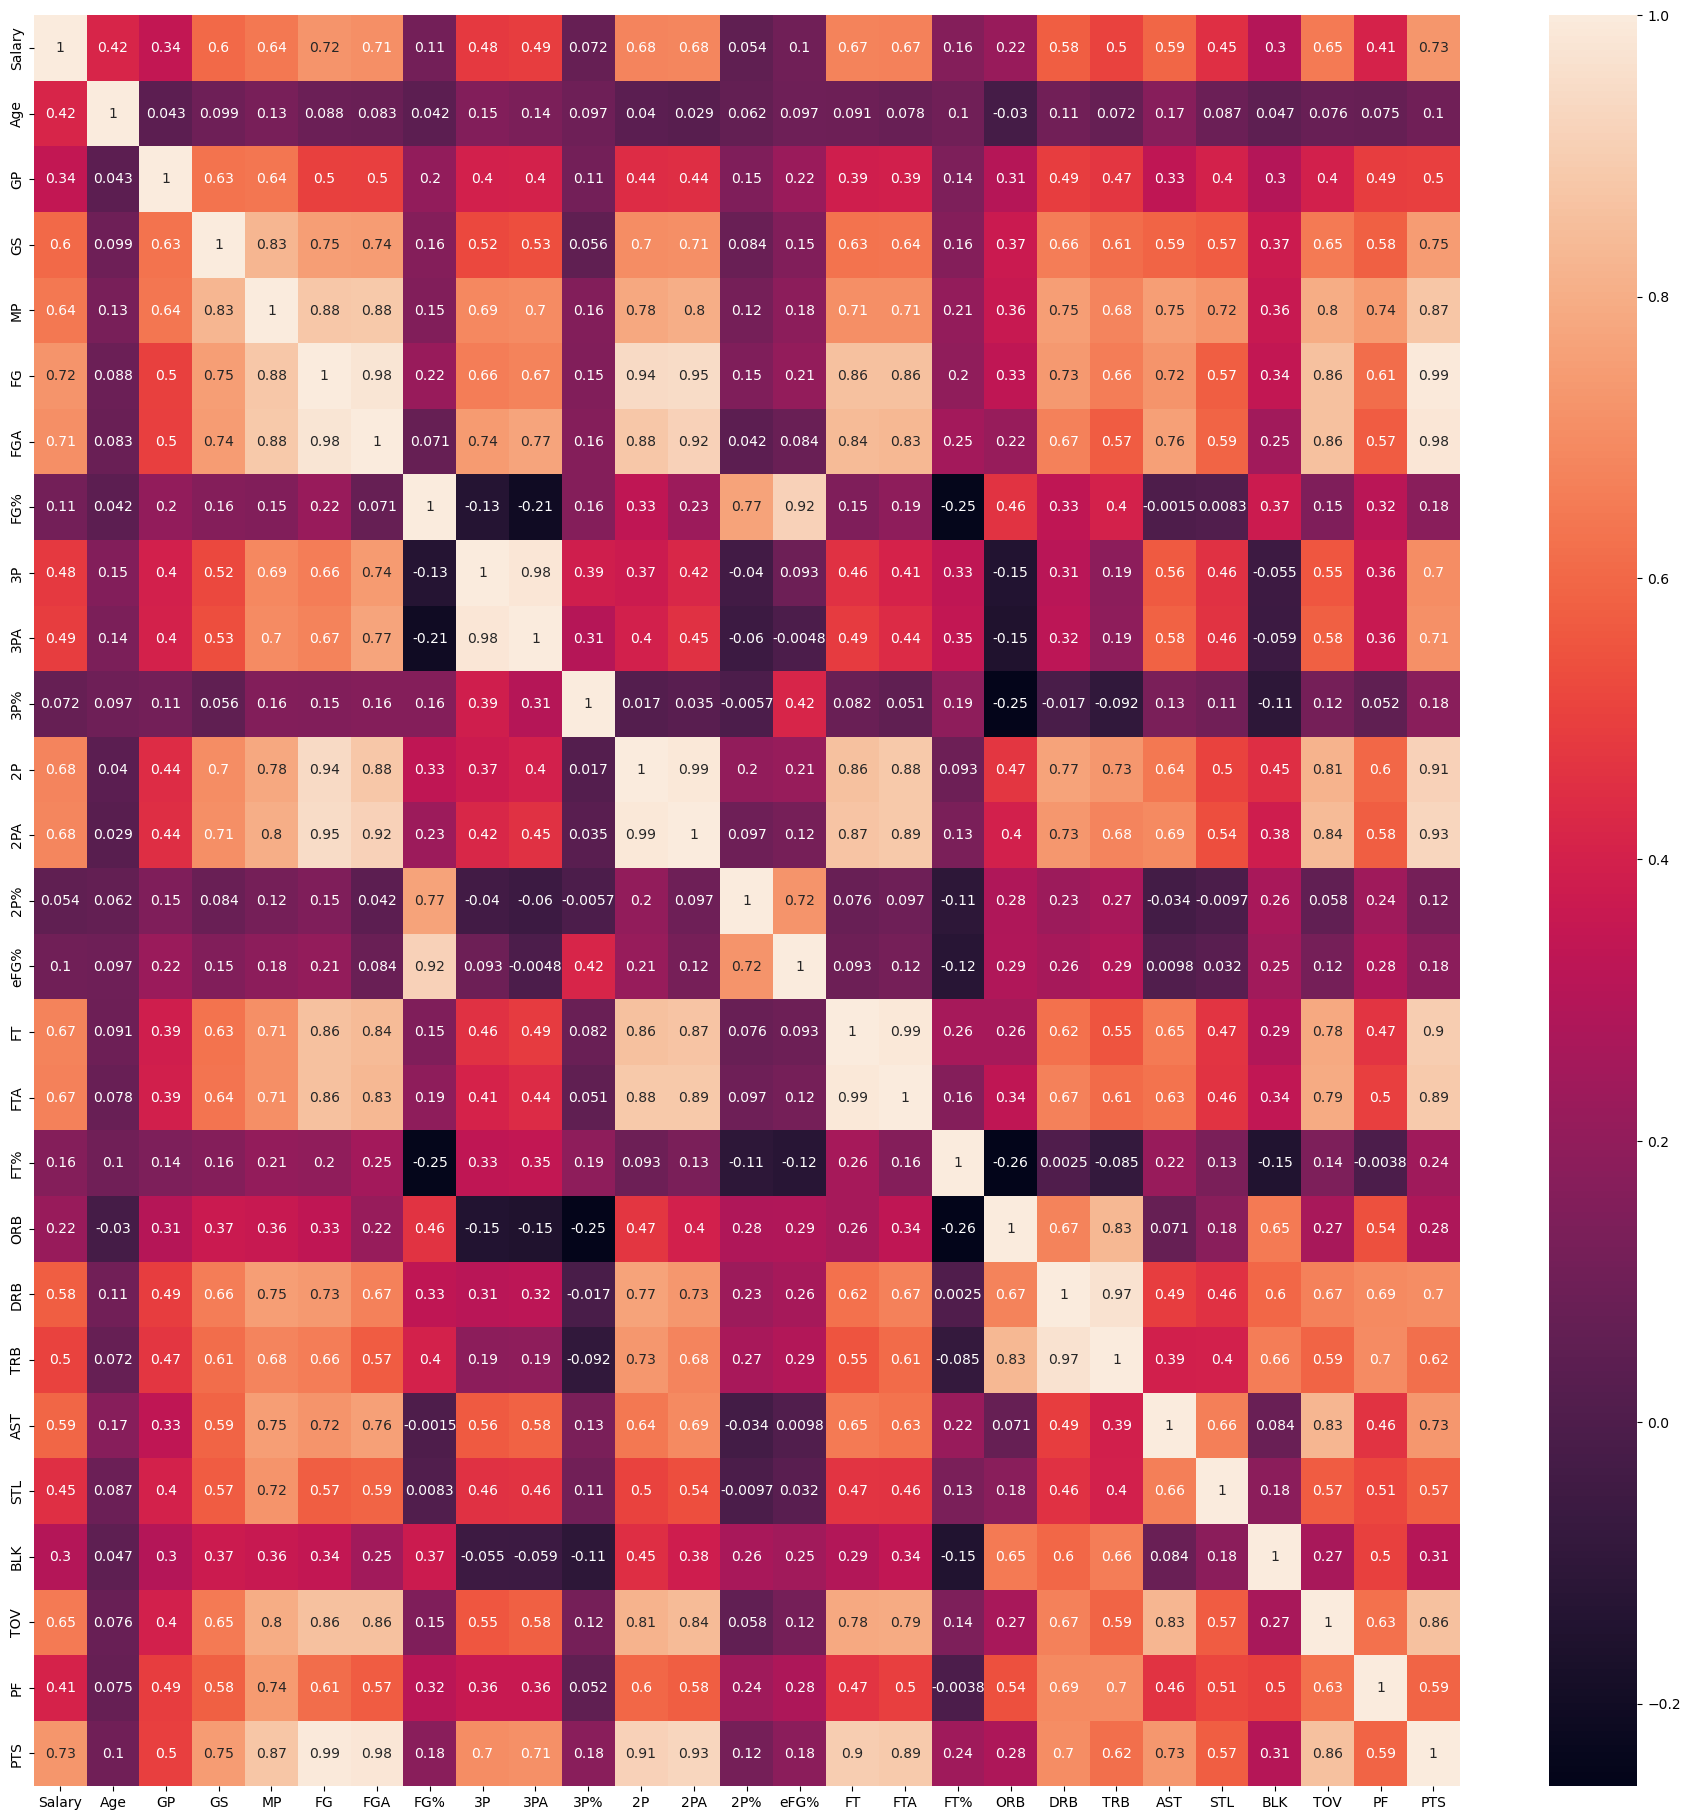

In [ ]:
relations = int_features.corr()
plt.figure(figsize=(23, 23))
sns.heatmap(data=relations, annot=True)

In [ ]:
int_features.drop("Salary", axis=1, inplace=True)

In [ ]:
points = np.linspace(10_000_000, 50_000_000, num=10)

[Text(0, 10000000.0, '10,000,000'),
 Text(0, 14444444.444444444, '14,444,444'),
 Text(0, 18888888.888888888, '18,888,889'),
 Text(0, 23333333.333333332, '23,333,333'),
 Text(0, 27777777.777777776, '27,777,778'),
 Text(0, 32222222.22222222, '32,222,222'),
 Text(0, 36666666.666666664, '36,666,667'),
 Text(0, 41111111.111111104, '41,111,111'),
 Text(0, 45555555.55555555, '45,555,556'),
 Text(0, 50000000.0, '50,000,000')]

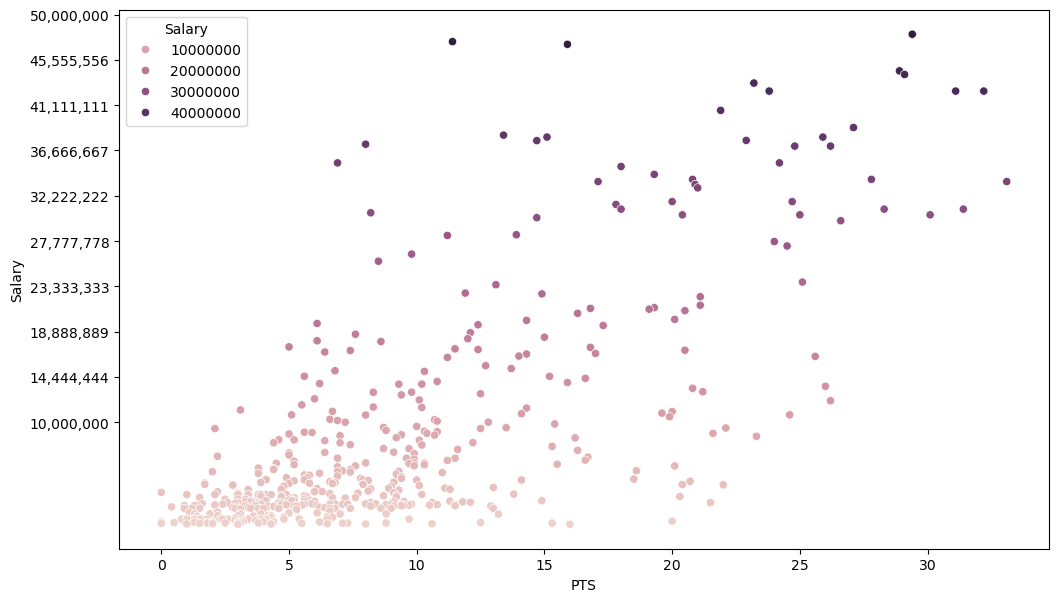

In [ ]:
plt.figure(figsize=(12, 7))
ax = sns.scatterplot(data=int_features, x="PTS", y="Salary", hue='Salary')

ax.set_yticks(points)
ax.set_yticklabels(['{:,.0f}'.format(x) for x in points])

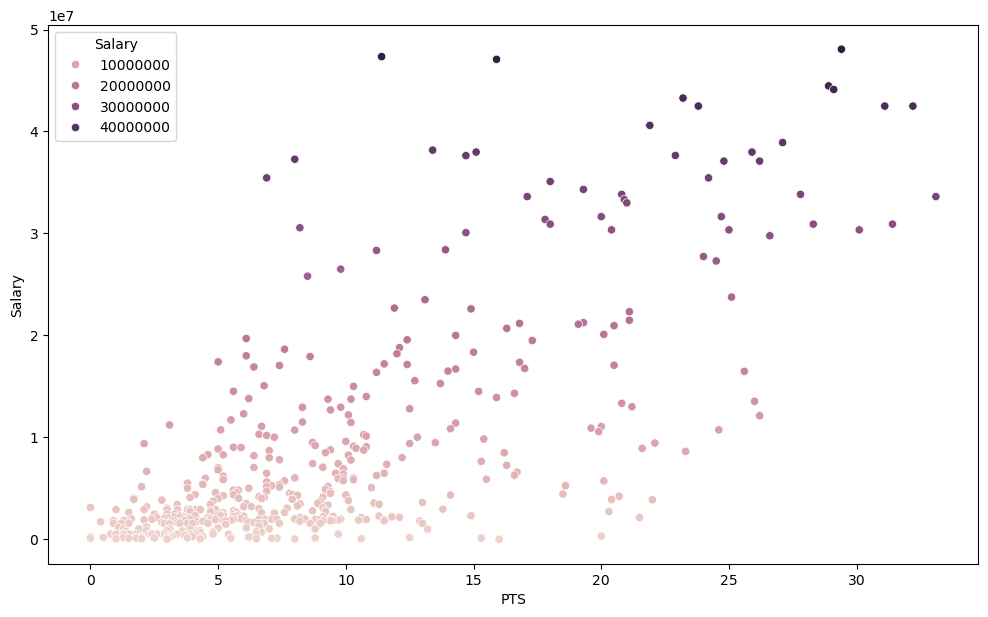

In [ ]:
plt.figure(figsize=(12, 7))
ax = sns.scatterplot(data=int_features, x="PTS", y="Salary", hue='Salary')

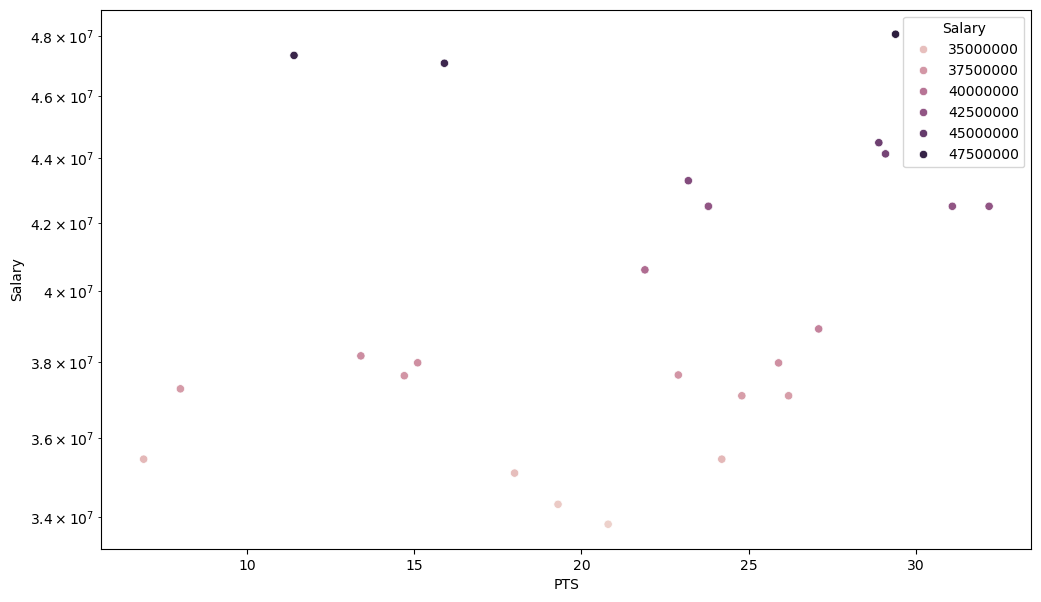

In [ ]:
plt.figure(figsize=(12, 7))
sns.scatterplot(data=top_twenty_five_paid, x="PTS", y="Salary", hue='Salary')
plt.yscale("log")

<AxesSubplot:xlabel='PTS', ylabel='FG'>

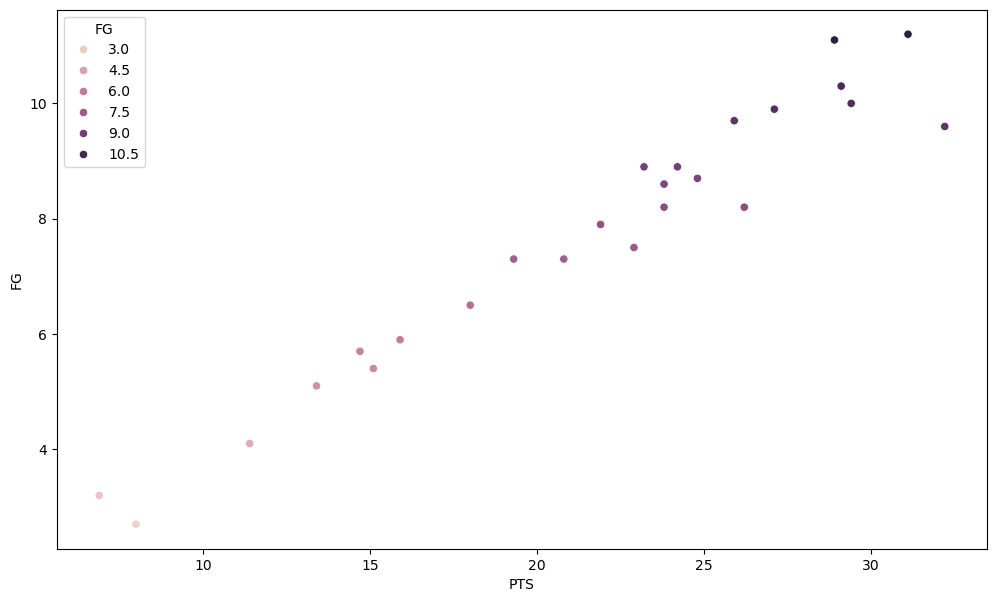

In [ ]:
plt.figure(figsize=(12, 7))

sns.scatterplot(data=top_twenty_five_paid, x="PTS", y="FG", hue='FG')

<AxesSubplot:xlabel='PTS', ylabel='2PA'>

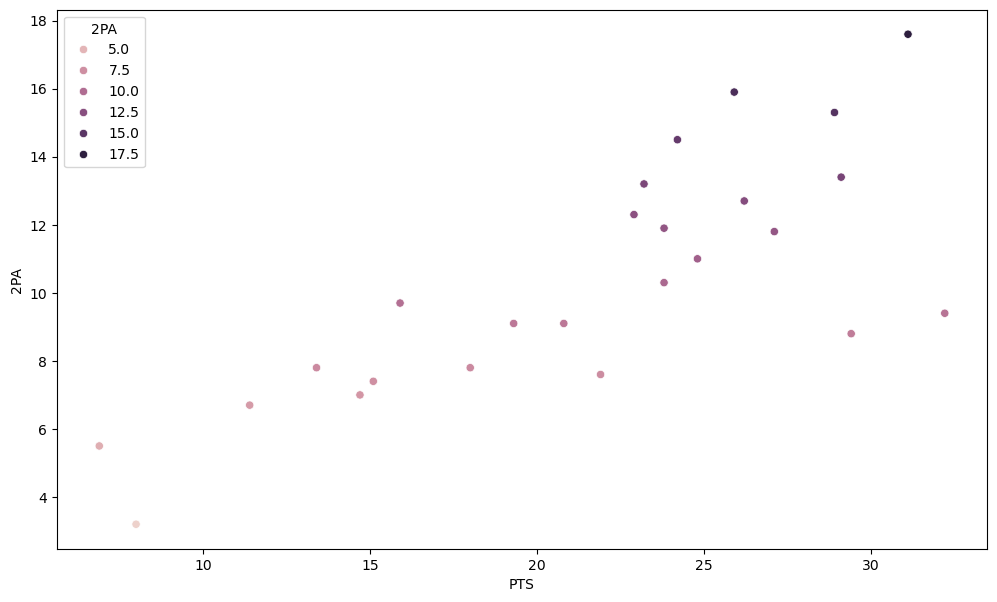

In [ ]:
plt.figure(figsize=(12, 7))

sns.scatterplot(data=top_twenty_five_paid, x="PTS", y="2PA", hue='2PA')

In [ ]:
grouped_df = player_salary.groupby("Team").sum("Salary").reset_index().sort_values(by="Salary", ascending=False)
grouped_df.head(25)



,Team,Salary,Age,GP,GS,MP,FG,FGA,FG%,3P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
33,LAC,214599173,350,618,322,260.8,45.9,97.4,5.458,14.0,...,7.730,9.0,37.0,46.3,28.2,7.7,4.9,15.0,20.7,127.0
26,GSW,191651594,403,789,410,320.6,56.1,117.7,7.141,22.1,...,11.565,13.4,43.6,56.7,39.8,9.7,5.3,22.4,27.9,154.9
46,MIL,187876425,478,762,406,332.0,58.8,124.0,7.307,20.2,...,12.508,15.6,51.7,67.6,35.8,8.5,6.5,20.3,26.5,161.2
1,BOS,171530254,430,828,406,320.8,53.0,111.6,7.436,19.1,...,12.137,15.2,47.7,62.9,34.2,8.9,7.4,16.7,25.6,146.4
44,MIA,145872879,421,698,384,339.2,54.4,116.9,7.051,15.9,...,11.921,15.3,43.1,58.3,31.8,11.1,4.3,17.6,28.8,150.5
66,SAC,137235649,493,926,407,290.9,50.6,103.7,8.730,15.4,...,11.394,13.2,39.1,52.3,31.9,8.5,4.6,16.4,26.1,138.7
52,NYK,134480498,322,751,401,285.4,48.9,106.2,6.057,15.1,...,9.101,14.5,39.5,54.1,26.3,7.2,5.0,13.9,23.6,134.3
59,PHI,132528674,336,671,320,293.2,58.9,117.6,6.491,19.5,...,9.468,12.2,39.3,51.5,36.3,8.9,5.1,18.1,25.2,164.5
0,ATL,123992839,329,715,394,267.9,48.8,101.1,6.535,9.3,...,9.956,13.3,39.3,52.6,27.4,8.0,5.4,13.9,21.0,126.7
14,CLE,122673411,419,777,407,314.6,52.5,108.1,7.866,14.7,...,12.154,11.8,38.7,50.5,32.1,10.4,6.0,15.4,25.2,141.0


In [ ]:
grouped_df.head(16)

,Team,Salary,Age,GP,GS,MP,FG,FGA,FG%,3P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
33,LAC,214599173,350,618,322,260.8,45.9,97.4,5.458,14.0,...,7.730,9.0,37.0,46.3,28.2,7.7,4.9,15.0,20.7,127.0
26,GSW,191651594,403,789,410,320.6,56.1,117.7,7.141,22.1,...,11.565,13.4,43.6,56.7,39.8,9.7,5.3,22.4,27.9,154.9
46,MIL,187876425,478,762,406,332.0,58.8,124.0,7.307,20.2,...,12.508,15.6,51.7,67.6,35.8,8.5,6.5,20.3,26.5,161.2
1,BOS,171530254,430,828,406,320.8,53.0,111.6,7.436,19.1,...,12.137,15.2,47.7,62.9,34.2,8.9,7.4,16.7,25.6,146.4
44,MIA,145872879,421,698,384,339.2,54.4,116.9,7.051,15.9,...,11.921,15.3,43.1,58.3,31.8,11.1,4.3,17.6,28.8,150.5
66,SAC,137235649,493,926,407,290.9,50.6,103.7,8.730,15.4,...,11.394,13.2,39.1,52.3,31.9,8.5,4.6,16.4,26.1,138.7
52,NYK,134480498,322,751,401,285.4,48.9,106.2,6.057,15.1,...,9.101,14.5,39.5,54.1,26.3,7.2,5.0,13.9,23.6,134.3
59,PHI,132528674,336,671,320,293.2,58.9,117.6,6.491,19.5,...,9.468,12.2,39.3,51.5,36.3,8.9,5.1,18.1,25.2,164.5
0,ATL,123992839,329,715,394,267.9,48.8,101.1,6.535,9.3,...,9.956,13.3,39.3,52.6,27.4,8.0,5.4,13.9,21.0,126.7
14,CLE,122673411,419,777,407,314.6,52.5,108.1,7.866,14.7,...,12.154,11.8,38.7,50.5,32.1,10.4,6.0,15.4,25.2,141.0


# Ironically the NBA Champions Salary is not in the top 16 teams of highest paid teams

In [ ]:
grouped_df[grouped_df["Team"] =="DEN"]

,Team,Salary,Age,GP,GS,MP,FG,FGA,FG%,3P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
19,DEN,96188221,265,553,265,198.5,32.9,64.8,5.185,8.1,...,6.712,8.9,23.7,32.8,18.9,6.1,4.2,9.7,15.8,85.9


In [ ]:
grouped_df.sort_values(by="PTS", ascending=False).head(16)

,Team,Salary,Age,GP,GS,MP,FG,FGA,FG%,3P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
59,PHI,132528674,336,671,320,293.2,58.9,117.6,6.491,19.5,...,9.468,12.2,39.3,51.5,36.3,8.9,5.1,18.1,25.2,164.5
46,MIL,187876425,478,762,406,332.0,58.8,124.0,7.307,20.2,...,12.508,15.6,51.7,67.6,35.8,8.5,6.5,20.3,26.5,161.2
65,POR,108123721,357,621,264,349.8,58.1,125.0,6.861,18.7,...,10.638,12.0,38.5,50.4,42.7,10.7,7.1,18.8,29.3,161.1
26,GSW,191651594,403,789,410,320.6,56.1,117.7,7.141,22.1,...,11.565,13.4,43.6,56.7,39.8,9.7,5.3,22.4,27.9,154.9
44,MIA,145872879,421,698,384,339.2,54.4,116.9,7.051,15.9,...,11.921,15.3,43.1,58.3,31.8,11.1,4.3,17.6,28.8,150.5
54,OKC,81346438,336,777,402,317.0,55.4,119.0,6.860,16.0,...,10.403,15.5,41.3,56.8,31.3,10.9,5.9,15.8,27.6,148.9
1,BOS,171530254,430,828,406,320.8,53.0,111.6,7.436,19.1,...,12.137,15.2,47.7,62.9,34.2,8.9,7.4,16.7,25.6,146.4
67,SAS,63107256,402,744,340,329.4,56.1,122.3,7.864,13.9,...,12.031,15.4,44.2,59.8,35.7,9.5,5.3,20.6,28.7,146.3
32,IND,100067648,374,707,390,306.5,52.0,114.6,6.711,17.6,...,11.323,12.9,40.1,53.2,31.0,9.9,8.6,15.9,28.3,144.7
72,UTA,91705319,406,651,305,288.3,52.5,112.4,7.344,15.2,...,9.717,14.5,41.2,55.6,29.7,6.3,6.6,17.7,24.3,143.3


# Create Preprocessor

In [ ]:
preprocessor = create_preprocessor(int_features.columns, cat_features.columns)
preprocessor

ColumnTransformer(transformers=[('Numeric',
                                 Pipeline(steps=[('Simple-Imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('Scaler', MinMaxScaler()),
                                                 ('PowerTransformer',
                                                  PowerTransformer())]),
                                 Index(['Age', 'GP', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P',
       '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('Encoder', OneHotEncoder())]),
                                 Index(['Position'], dtype='object'))])

# Separate Features

In [ ]:
X = player_salary.drop("Salary", axis=1)
y = player_salary["Salary"]

# PCA Analysis

In [ ]:
pca_analysis(X, preprocessor)

,Component,CumSum
0,1,0.508411
1,2,0.649162
2,3,0.725686
3,4,0.765617
4,5,0.802390
5,6,0.833237
6,7,0.859793
7,8,0.881678
8,9,0.902335
9,10,0.916435


# We can see how the having more columns does not bring additional performance up until the cut off point

# Create Metrics

In [17]:
MAE = make_scorer(score_func=mean_absolute_error, greater_is_better =False)
MSE = make_scorer(score_func=mean_squared_error, greater_is_better=False)
R2 = make_scorer(score_func=r2_score, greater_is_better=True)
EXP_VAR = make_scorer(score_func=explained_variance_score, greater_is_better=True)

# Baseline Model